# SMS Spam Detection Project

In this project, we build a machine learning pipeline to detect spam SMS messages based on their text content.  
We explore the dataset, clean the text data, create TF-IDF features, train multiple models, and save the best one.

# Data Loading

We load the SMS Spam Collection dataset directly from the UCI Machine Learning Repository.

In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Download dataset directly from UCI ML Repository
data_url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"

# Load the dataset
data = pd.read_csv(data_url, sep='\t', header=None, names=['label', 'message'])

# Quick look
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Data Exploration and Cleaning

We check for missing values, explore class distribution, and map labels (ham = 0, spam = 1).

In [2]:
# Basic dataset info
print(f"Dataset has {data.shape[0]} rows and {data.shape[1]} columns.\n")
print("Data Types and Null Values:")
print(data.info())
print("\nMissing Values:\n", data.isnull().sum())

Dataset has 5572 rows and 2 columns.

Data Types and Null Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

Missing Values:
 label      0
message    0
dtype: int64


In [3]:
# Map labels: ham -> 0, spam -> 1
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# Confirm mapping
data['label'].value_counts()

label
0    4825
1     747
Name: count, dtype: int64

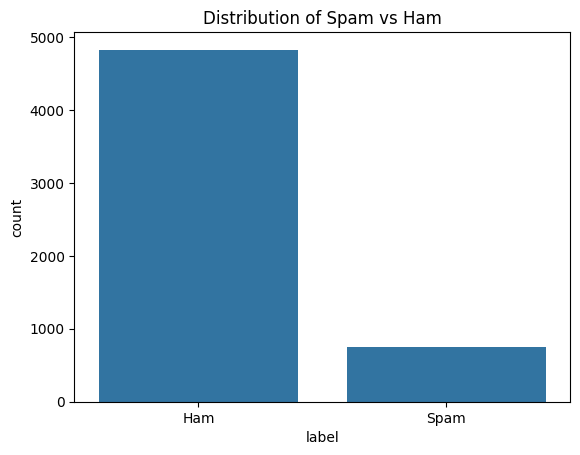

In [4]:
# Plot class distribution
sns.countplot(x='label', data=data)
plt.title('Distribution of Spam vs Ham')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.show()

# Text Preprocessing

We clean the text by lowercasing, removing punctuation, and removing stopwords to prepare for vectorization.

In [5]:
import string
from nltk.corpus import stopwords

def clean_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]
    
    return ' '.join(words)

In [6]:
# Apply cleaning function
data['cleaned_message'] = data['message'].apply(clean_text)

# Quick look
data[['message', 'cleaned_message']].head()

,message,cleaned_message
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


# Feature Engineering (TF-IDF)

We use TF-IDF vectorization to create numerical feature vectors that weigh rare but important words more heavily.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [8]:
# Define features and labels
X = data['cleaned_message']
y = data['label']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 4457
Testing samples: 1115


In [9]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=3000)

# Fit on training data, transform both train and test
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train and Evaluate Models

We train Naive Bayes, Logistic Regression, and Random Forest classifiers, and evaluate their performance using Accuracy, Precision, Recall, and F1-Score.

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(y_true, y_pred):
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

In [11]:
from sklearn.naive_bayes import MultinomialNB

# Train Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

# Predict
nb_preds = nb.predict(X_test_tfidf)

# Evaluate
print("Naive Bayes Results:")
evaluate_model(y_test, nb_preds)

Naive Bayes Results:
Accuracy: 0.9713
Precision: 0.9916
Recall: 0.7919
F1-Score: 0.8806
Confusion Matrix:
[[965   1]
 [ 31 118]]


In [12]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

# Predict
lr_preds = lr.predict(X_test_tfidf)

# Evaluate
print("\nLogistic Regression Results:")
evaluate_model(y_test, lr_preds)


Logistic Regression Results:
Accuracy: 0.9677
Precision: 1.0000
Recall: 0.7584
F1-Score: 0.8626
Confusion Matrix:
[[966   0]
 [ 36 113]]


In [13]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

# Predict
rf_preds = rf.predict(X_test_tfidf)

# Evaluate
print("\nRandom Forest Results:")
evaluate_model(y_test, rf_preds)


Random Forest Results:
Accuracy: 0.9785
Precision: 1.0000
Recall: 0.8389
F1-Score: 0.9124
Confusion Matrix:
[[966   0]
 [ 24 125]]


# ROC-AUC Curves

We plot ROC-AUC curves to visually compare the ability of each model to distinguish between spam and ham messages.

In [14]:
from sklearn.metrics import roc_curve, auc

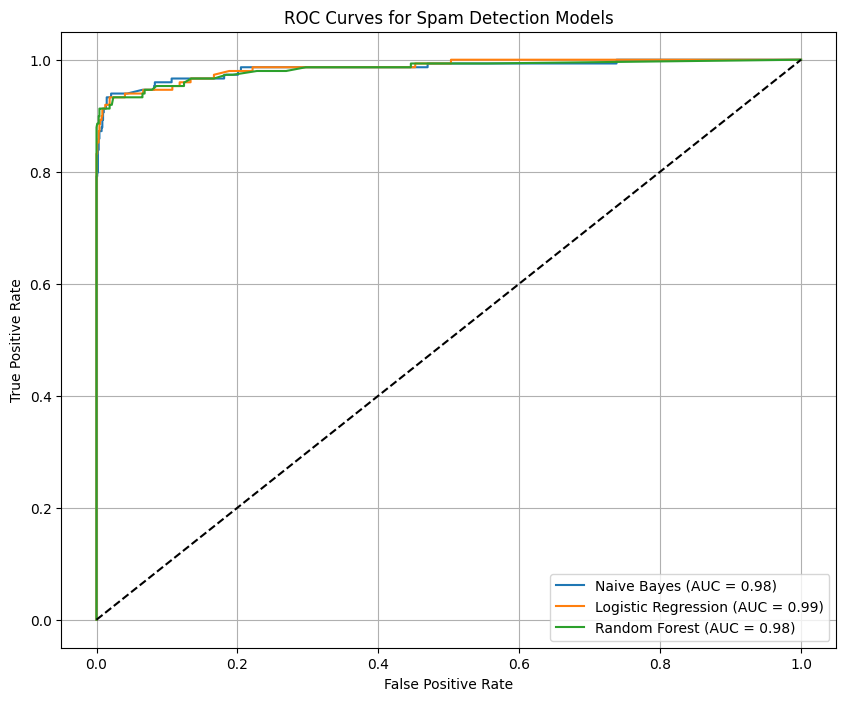

In [15]:
import matplotlib.pyplot as plt

# Start plotting
plt.figure(figsize=(10, 8))

# Naive Bayes
nb_probs = nb.predict_proba(X_test_tfidf)[:, 1]
fpr1, tpr1, _ = roc_curve(y_test, nb_probs)
auc1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, label=f'Naive Bayes (AUC = {auc1:.2f})')

# Logistic Regression
lr_probs = lr.predict_proba(X_test_tfidf)[:, 1]
fpr2, tpr2, _ = roc_curve(y_test, lr_probs)
auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label=f'Logistic Regression (AUC = {auc2:.2f})')

# Random Forest
rf_probs = rf.predict_proba(X_test_tfidf)[:, 1]
fpr3, tpr3, _ = roc_curve(y_test, rf_probs)
auc3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label=f'Random Forest (AUC = {auc3:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], linestyle='--', color='black') # random guess line
plt.title('ROC Curves for Spam Detection Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# Final Model Selection and Saving

Based on the evaluation metrics, we select the best model and save it for future use.

In [16]:
import pandas as pd

# Create a simple results summary (you can fill in with your actual values if you want)
results = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression', 'Random Forest'],
    'AUC': [auc1, auc2, auc3]
})

# Sort by AUC
results = results.sort_values(by='AUC', ascending=False)

print(results)

                 Model       AUC
1  Logistic Regression  0.985997
0          Naive Bayes  0.984781
2        Random Forest  0.983617


In [17]:
import joblib

# Save Logistic Regression model
joblib.dump(lr, 'spam_detector_best_model.pkl')

print("Best model saved as 'spam_detector_best_model.pkl'.")

Best model saved as 'spam_detector_best_model.pkl'.


# Conclusion

In this project, Logistic Regression achieved the highest AUC and best overall spam detection performance.

Key learnings:
- Proper text preprocessing significantly improves classification performance.
- TF-IDF vectorization is a powerful technique for feature engineering in NLP tasks.
- Comparing multiple models (and not relying only on accuracy) gives better real-world results.

Future improvements could include:
- Hyperparameter tuning,
- Trying deep learning models (e.g., simple LSTM),
- Deploying the model into a web app (using Streamlit or Flask).